In [1]:
# Load the network

from __future__ import print_function
import argparse
import torch
import data_loader
import numpy as np
import calculate_log as callog
import models
import os
import lib_generation

from torchvision import transforms
from torch.autograd import Variable

# set the path to pre-trained model and output
pre_trained_net = './pre_trained/resnet_cifar10.pth'

torch.cuda.set_device(0)

# check the in-distribution dataset
out_dist_list = ['svhn', 'imagenet_resize', 'lsun_resize']

# load networks
model = models.ResNet34(num_c=10)
model.load_state_dict(torch.load(pre_trained_net, map_location = "cuda:" + str(0)))
in_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [2]:
from torchvision import datasets

cifar10_train = torch.utils.data.DataLoader(
    datasets.CIFAR10('/media/tadenoud/DATADisk/datasets/cifar10/', train=True, transform=in_transform),
    batch_size=128, num_workers=2, pin_memory=True)
    
cifar10_val = torch.utils.data.DataLoader(
    datasets.CIFAR10('/media/tadenoud/DATADisk/datasets/cifar10/', train=False, transform=in_transform),
    batch_size=128, num_workers=2, pin_memory=True)

svhn_val = torch.utils.data.DataLoader(
    datasets.SVHN('/media/tadenoud/DATADisk/datasets/svhn', split='test', transform=in_transform),
    batch_size=128, num_workers=2, pin_memory=True)

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
from tqdm.auto import tqdm

# Build the Mahalanobis Detector

all_features = np.empty((0,512))
all_labels = np.empty(0)

for X, Y in tqdm(cifar10_train, total=len(cifar10_train)):
    X = X.to(device)
    
    _, features = model.penultimate_forward(X)
    
    features = features.view((features.size(0), features.size(1), -1))
    features = torch.mean(features, 2)
    
    features = features.detach().cpu().numpy()
    
    all_features = np.concatenate((all_features, features), axis=0)
    all_labels = np.concatenate((all_labels, Y.detach().cpu().numpy()), axis=0)

In [6]:
num_classes = 10
import sklearn.covariance

def estimate_mahalanobis_parameters(features, labels, return_tensor=False):
    class_means = []
    centered_features = features.copy()

    for i in range(num_classes):
        mask = labels == i

        # Calculate the class mean
        class_means.append(features[mask].mean(axis=0))

        # Create mean subtracted features for covariance estimation
        centered_features[mask] -= class_means[i]


    # Calculate the inverted covariance matrix
    group_lasso = sklearn.covariance.EmpiricalCovariance(assume_centered=False)
    group_lasso.fit(centered_features)
    precision = group_lasso.precision_
    covariance = group_lasso.covariance_
    
    if return_tensor:
        class_means = torch.from_numpy(np.array(class_means)).float().cuda()
        precision = torch.from_numpy(precision).float().cuda()
        covariance = torch.from_numpy(covariance).float().cuda()
    
    return class_means, precision, covariance

In [7]:
# Run the detector on CIFAR-10 val and SVHN and compare results
class_means, precision, _ = estimate_mahalanobis_parameters(all_features, all_labels, return_tensor=True)

In [8]:
def mahalanobis_distance(features, means, inv_mahal_cov, device):   
    """Return a matrix with dist to each mean for each feature in the features batch."""
    # Tile the features and means to vectorize the operation
    num_means = means.shape[0]
    num_feats = features.shape[0]

    features = features.repeat(1, num_means).view(-1, features.shape[1])

    # subtract means in batches
    x = features - means.repeat(num_feats, 1)

    # matmul, take diagonal, then reshape
    dists = x.mm(inv_mahal_cov).mm(x.transpose(0,1)).diag()
    dists = dists.view(num_feats, num_means).transpose(0,1)

    min_dists, labels = dists.min(dim=0)
    return labels, min_dists


def get_mahalanobis_distances(model, class_means, precision, device, id_loader, ood_loader):
    """Get the distance to the nearest class_mean and return that distance and the class label for
        all data in the id_loader and ood_loader."""
    model.eval()
    min_dists = []
    labels = []
    
    with torch.no_grad():
        for data, target in tqdm(id_loader, total=len(id_loader)):
            data, target = data.to(device), target.to(device)
            _, features = model.penultimate_forward(data)
            features = features.view((features.size(0), features.size(1), -1))
            features = torch.mean(features, 2)
            pred, min_dist = mahalanobis_distance(features, class_means, precision, device)
            min_dists.append(min_dist.detach().cpu().numpy())
            labels.append(target.detach().cpu().numpy())
            
        for data, target in tqdm(ood_loader, total=len(ood_loader)):
            data, target = data.to(device), target.to(device)
            _, features = model.penultimate_forward(data)
            features = features.view((features.size(0), features.size(1), -1))
            features = torch.mean(features, 2)
            pred, min_dist = mahalanobis_distance(features, class_means, precision, device)
            min_dists.append(min_dist.detach().cpu().numpy())
            labels.append(np.ones(len(target)) * -1)
            
    return np.concatenate(min_dists), np.concatenate(labels)

In [9]:
dists, labels = get_mahalanobis_distances(model, class_means, precision, device, cifar10_val, svhn_val)

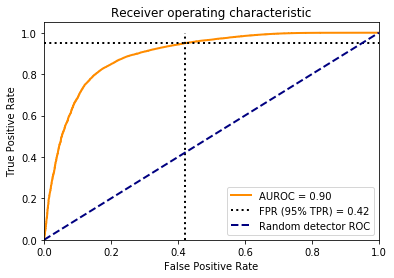

{'fpr_at_95_tpr': 0.4222,
 'detection_error': 0.2360884757221881,
 'auroc': 0.8953546634910878,
 'aupr_in': 0.945451290166519,
 'aupr_out': 0.8128311274565988}

In [15]:
%matplotlib inline

from ood_metrics import calc_metrics, plot_roc

labels[:10000] = 0
labels[10000:] = 1

plot_roc(dists, labels)
calc_metrics(dists, labels)
